# Práctica 2

## Preparación de entorno

In [49]:
import numpy as np
import keras as ker
import matplotlib.pyplot as plt 
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

## SETUP

### Lectura y limpieza dataset

In [50]:
cancer = pd.read_csv("cancer_dataset.csv", encoding = 'latin_1', sep = ',')
cancer = cancer.drop(columns=['id'], axis=1) # No sirve

aleatorizar = True # TOCAR

cancerentreno, cancerpredecir = train_test_split(cancer, test_size = 0.30, shuffle=aleatorizar) # El entreno es el 70% y el conjunto prueba 30%
esperadas_entreno = cancerentreno.pop("diagnosis")
esperadas_predecir = cancerpredecir.pop("diagnosis")

### Variables a definir

In [51]:
# Normalización entradas en base a máximo y mínimo (máximo es 1 - mínimo es 0)

cancerentreno = (cancerentreno - cancerentreno.min()) / (cancerentreno.max() - cancerentreno.min())
cancerpredecir = (cancerpredecir - cancerpredecir.min()) / (cancerpredecir.max() - cancerpredecir.min())

entradas =  cancerentreno.to_numpy() # Las 30 posibles variables
esperadas = esperadas_entreno.to_numpy() # Array de B/M con el diagnóstico

# Categorizamos el diagnostico de entreno (M = 1 / B = 0)
label_encoder = LabelEncoder()
esperadas = label_encoder.fit_transform(esperadas)

# Categorizamos el diagnostico de predicción (M = 1 / B = 0)
esperadas_predecir = label_encoder.fit_transform(esperadas_predecir)


nNeuronasCapaOculta = 12 # Tocar
nCapasOcultas = 5 # Tocar
Epoch = 500 # Tocar
tam_entrada = cancerentreno.shape[1] # Tamaño de la capa de entrada = columnas
automatizador = True # Ejecutar el automatizador para encontrar los parametros que mas se ajustan a los datos

def validar_neuronas_oculta(M,N,n): # Empleamos esta funcion para validar que las neuronas de la capa oculta cumplen con la regla aprendida en clase
    # La regla a validar es (M/2N < n < 2M/N)
    # Siendo M: ejemplos de entrenamiento // N: neuronas de entrada // n: neuronas de la capa oculta
    if((M/(2*N)) < n and n < ((2*M)/N)):
        return print("Neuronas de la capa oculta cumple regla") # validamos
    return print("Neuronas de la capa oculta no cumple regla")

validar_neuronas_oculta(cancerentreno.shape[0],tam_entrada,nNeuronasCapaOculta)

Neuronas de la capa oculta cumple regla


### Creación y ajuste de la red

In [52]:
def initRed(nNeuronasCapaOculta,nCapasOcultas):
    MLP = ker.Sequential() # Creamos el modelo vacío

    # Añadimos la primera capa (tecnicamente dos, la de entrada (con la variable input_dim) y la oculta)
    MLP.add(ker.layers.Dense(nNeuronasCapaOculta, input_dim = tam_entrada, activation='relu'))

    # Añadimos tantas capas ocultas extra como queramos (siempre como mínimo hay 1, la creada anteriormente)
    for i in range(nCapasOcultas):
        MLP.add(ker.layers.Dense(nNeuronasCapaOculta, activation='relu'))

    # Añadimos la capa de salida
    MLP.add(ker.layers.Dense(1,activation='sigmoid')) 

    # MLP.summary()

    # Por último tenemos que configurar el modelo antes de entrenarlo con lo dicho en el enunciado
    # Optimizador: Adam
    # Función error: Mean Squared Error
    # Metricas = Binary accuracy porque nos da el número de precisión de la red
    MLP.compile(optimizer='adam',loss='mean_squared_error',metrics=["binary_accuracy"])
    return MLP


### Entrenamiento de la red

In [53]:
def entrenar(MLP,Epoch):
    # Por último entrenamos la red con el epoch (nº iteraciones)
    output_fit = MLP.fit(entradas,esperadas,epochs=Epoch,verbose = 0) 
    return output_fit

### Calidad de la red

In [54]:
def pintarExact(output_fit):
    print(output_fit.history.keys())
    # Pintamos las tanto la loss como la accuracy
    plt.plot(output_fit.history['loss'])
    plt.plot(output_fit.history['binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Error', 'Exactitud'], loc='lower left')
    plt.show()

def evaluar(MLP):
    # Evaluamos el modelo
    print("Datos evaluadis")
    evaluar = MLP.evaluate(entradas, esperadas,verbose=0)
    print("Error, Exactitud:", evaluar)
    return MLP

def evaluarAuto(MLP):
    return MLP.evaluate(entradas, esperadas,verbose=0)

### Prueba de la red

In [55]:
def prueba(MLP):
    # Una vez tenemos entrenada la red, probamos todas las entradas y vemos si funciona
    i = 0
    fallos = 0
    resultados = MLP.predict(cancerpredecir).round()
    error = ""
    print("================ EXACTITUD ================")
    for resultado in resultados:
        if(resultado != esperadas_predecir[i]):
            fallos += 1
            error = "ERROR"
        print("PREDICHO ->", resultado, " ESPERADO ->", esperadas_predecir[i], error)
        i += 1
        error = ""
    print("Número de fallos: ", fallos, " de ", cancerpredecir.shape[0], "porcentaje de fallo: ", fallos/cancerpredecir.shape[0])

In [56]:
if not automatizador:
    validar_neuronas_oculta(cancerentreno.shape[0],tam_entrada,nNeuronasCapaOculta)
    MLP = initRed(nNeuronasCapaOculta,nCapasOcultas)
    output_fit = entrenar(MLP,Epoch)
    pintarExact(output_fit)
    MLP = evaluar(MLP)
    prueba(MLP)

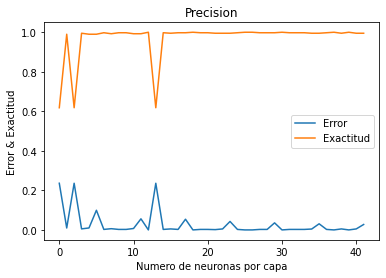

In [57]:
# neuronas
if automatizador:
    neuronas = [i for i in range(5,40,5)]
    capas = [i for i in range(2,20,4)]
    epochs = [i for i in range(50,1000,25)]
    precision = 5
    # Una vez hemos inicializado, podemos empezar a iterar con las listas creadas para encontrar la mejor configuración para los datos 
    err = []
    ex = []
    outputErr = [err,ex]
    for neurona in neuronas:
        print("Numero de neuronas:",neurona,end="\r")
        for i in range(precision):
            MLP = initRed(neurona,capas[int(len(capas)/2)])
            output_fit = entrenar(MLP,epochs[int(len(epochs)/2)])
            error,exact = evaluarAuto(MLP)
            err.append(error)
            ex.append(exact)
        outputErr[0].append(np.mean(err))
        outputErr[1].append(np.mean(exact))
    # Ahora pintamos la grafica para ver el error y la precisión
    plt.title('Precision')
    plt.plot(outputErr[0])
    plt.plot(outputErr[1])
    plt.legend(['Error', 'Exactitud'], loc='center right')
    plt.ylabel('Error & Exactitud')
    plt.xlabel('Numero de neuronas por capa')
    plt.show()

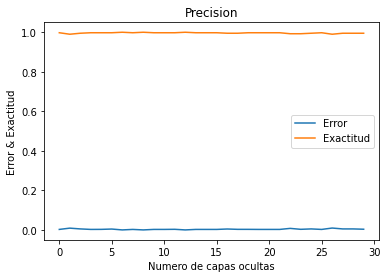

In [58]:
# capas
if automatizador:
    neuronas = [i for i in range(5,40,5)]
    capas = [i for i in range(2,20,4)]
    epochs = [i for i in range(50,1000,25)]
    precision = 5
    # Una vez hemos inicializado, podemos empezar a iterar con las listas creadas para encontrar la mejor configuración para los datos 
    err = []
    ex = []
    outputErr = [err,ex]
    for capa in capas:
        print("Numero de capas:",neurona,end="\r")
        for i in range(precision):
            MLP = initRed(neuronas[int(len(neuronas)/2)],capa)
            output_fit = entrenar(MLP,epochs[int(len(epochs)/2)])
            error,exact = evaluarAuto(MLP)
            err.append(error)
            ex.append(exact)
        outputErr[0].append(np.mean(err))
        outputErr[1].append(np.mean(exact))
    # Ahora pintamos la grafica para ver el error y la precisión
    plt.title('Precision')
    plt.plot(outputErr[0])
    plt.plot(outputErr[1])
    plt.legend(['Error', 'Exactitud'], loc='center right')
    plt.ylabel('Error & Exactitud')
    plt.xlabel('Numero de capas ocultas')
    plt.show()

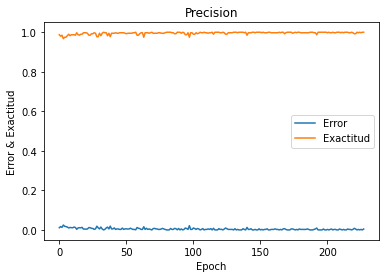

In [59]:
# epoch
if automatizador:
    neuronas = [i for i in range(5,40,5)]
    capas = [i for i in range(2,20,4)]
    epochs = [i for i in range(50,1000,25)]
    precision = 5
    # Una vez hemos inicializado, podemos empezar a iterar con las listas creadas para encontrar la mejor configuración para los datos 
    err = []
    ex = []
    outputErr = [err,ex]
    for epoch in epochs:
        print("Epoch:",epoch,end="\r")
        for i in range(precision):
            MLP = initRed(neuronas[int(len(neuronas)/2)],capas[int(len(capas)/2)])
            output_fit = entrenar(MLP,epoch)
            error,exact = evaluarAuto(MLP)
            err.append(error)
            ex.append(exact)
        outputErr[0].append(np.mean(err))
        outputErr[1].append(np.mean(exact))
    # Ahora pintamos la grafica para ver el error y la precisión
    plt.title('Precision')
    plt.plot(outputErr[0])
    plt.plot(outputErr[1])
    plt.legend(['Error', 'Exactitud'], loc='center right')
    plt.ylabel('Error & Exactitud')
    plt.xlabel('Epoch')
    plt.show()